Create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/ubuntu/seg-anything/segment-anything/notebooks


conda create -n sam python=3.8 opencv=4.4.0 -c conda-forge

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

conda install jupyter

conda install matplotlib

conda install pandas

## Load Model

In [2]:
import torch

DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_b"

In [3]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-yw5uswv8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-yw5uswv8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=25032c8d326d13bb0f162cf4c031d375457284fc64871b3c8cabf41e19bf51d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7hz5z_i/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment_anything


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '../weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

predictor = SamPredictor(sam)

## Upload Image(s)

In [6]:
from PIL import Image
import cv2
import numpy as np

def process_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Verify if the image is loaded
    if image is None:
        print(f'Could not open or find the image: {image_path}')
        return None
    
    # Convert the OpenCV image to a PIL Image for easier manipulation
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Calculate the 20% zoom parameters
    width, height = image_pil.size
    new_width = width * 0.8
    new_height = height * 0.8
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    
    # Crop the center of the image to achieve the zoom effect
    image_zoomed = image_pil.crop((left, top, right, bottom))
    
    # Resize the image to 512x512
    image_resized = image_zoomed.resize((512, 512), Image.Resampling.LANCZOS)
    
    # Convert back to OpenCV format
    image_final = cv2.cvtColor(np.array(image_resized), cv2.COLOR_RGB2BGR)
    
    return image_final

In [8]:
import glob

# Path to the directory with images
imgs_path = '../../PDS_Image_Retrieve/imgs'

# Get a list of all jpeg files in the directory
imgs_files = glob.glob(os.path.join(imgs_path, '*.png'))

# Initialize an empty list to store the images
imgs = []

# Restrict how many
restrict = 0

# Loop over all files
for img_file in imgs_files:
    restrict += 1
    if restrict == 5:
        break
    # Read the image
    img = process_image(img_file)

    # Verify if the image is loaded
    if img is None:
        print(f'Could not open or find the image: {img_file}')
    else:
        # Get the dimensions of the image
        height, width, channels = img.shape

        imgs.append(img)

print(f"Successfully loaded {len(imgs)} images from {imgs_path}")

Successfully loaded 3 images from ../../PDS_Image_Retrieve/imgs


Make sure we imported right by displaying an image

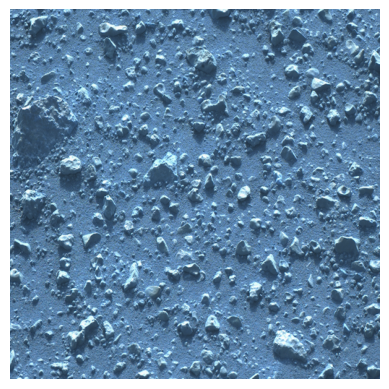

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(imgs[0])
plt.axis('off')  # Hide the axis
plt.show()

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [11]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

### Generate masks with SAM

In [12]:
import cv2

results = []
# for i in range(1):
#   image = imgs[i]
#   sam_result = mask_generator.generate(image)
#   results.append(sam_result)
image = imgs[0]
sam_result = mask_generator.generate(image)
results.append(sam_result)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

save_path = '../dataset'
average_area = 0
total_segments = 0

# Function to calculate long and short axes from bbox
def calculate_axes(bbox):
    width, height = bbox[2], bbox[3]
    return max(width, height), min(width, height)

# Create the images and labels directories if not exist
os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'labels'), exist_ok=True)

for i in range(len(results)):
    img = imgs[i].copy()
    img_num = "{:03}".format(i)
    entry = {"img_num": img_num, "bboxes": [], "polygons": [], "areas": [], "long_axes": [], "short_axes": []}
    bboxes = []
    polygons = []
    areas = []
    long_axes = []
    short_axes = []

    for j, result in enumerate(results[i]):
        if result['area'] > 10000:
            continue
        
        # Append area
        areas.append(result['area'])
        average_area += result['area']
        total_segments += 1

        # Append bbox and calculate axes
        bboxes.append(result['bbox'])
        long_axis, short_axis = calculate_axes(result['bbox'])
        long_axes.append(long_axis)
        short_axes.append(short_axis)

        # Process mask and find contours
        mask = (result['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons += [cv2.approxPolyDP(contour, 1, True).tolist() for contour in contours]

        # Optionally, draw contours on the image for visualization
        cv2.drawContours(img, contours, -1, (0, 255, 0), 2)

    entry["bboxes"] = bboxes
    entry["polygons"] = polygons
    entry["areas"] = areas
    entry["long_axes"] = long_axes
    entry["short_axes"] = short_axes

    # Save the processed image
    img_path = os.path.join(save_path, 'images', f'{img_num}.png')
    cv2.imwrite(img_path, img)

    # Save the metadata as a JSON file
    json_path = os.path.join(save_path, 'labels', f'{img_num}.json')
    with open(json_path, 'w') as f:
        json.dump(entry, f)


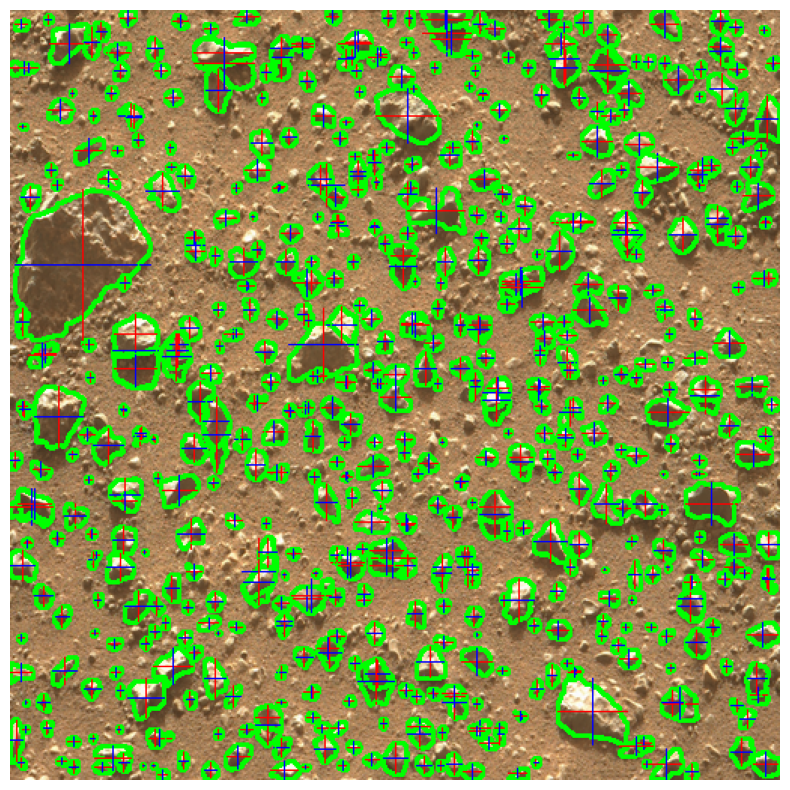

In [42]:
# Assuming `img` is the last processed image from the loop above and still in memory,
# and that you have the corresponding `results` for that image.

plt.figure(figsize=(10, 10))

# Convert image to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')

# Loop through the segments to draw additional details
for result, bbox, polygon in zip(results[-1], entry['bboxes'], entry['polygons']):
    if result['area'] > 10000:
        continue
    
    # Draw long and short axes
    x_min, y_min, width, height = bbox
    center_x, center_y = x_min + width // 2, y_min + height // 2
    center = (int(x_min + width / 2), int(y_min + height / 2))
    long_axis = max(width, height)
    short_axis = min(width, height)
    
    # Calculate endpoints for the long axis
    if width >= height:  # Horizontal orientation
        start_long = (center[0] - long_axis // 2, center[1])
        end_long = (center[0] + long_axis // 2, center[1])
        start_short = (center[0], center[1] - short_axis // 2)
        end_short = (center[0], center[1] + short_axis // 2)
    else:  # Vertical orientation
        start_long = (center[0], center[1] - long_axis // 2)
        end_long = (center[0], center[1] + long_axis // 2)
        start_short = (center[0] - short_axis // 2, center[1])
        end_short = (center[0] + short_axis // 2, center[1])
    
    # Draw the axes on the image
    cv2.line(img_rgb, start_long, end_long, (255, 0, 0), 1)  # Red for long axis
    cv2.line(img_rgb, start_short, end_short, (0, 0, 255), 1)  # Blue for short axis
    
    # Optionally, draw simplified polygon contours with a thinner line
    for poly in polygon:
        pts = np.array(poly, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 1)

# Redisplay the image with the additional annotations
plt.imshow(img_rgb)
plt.show()


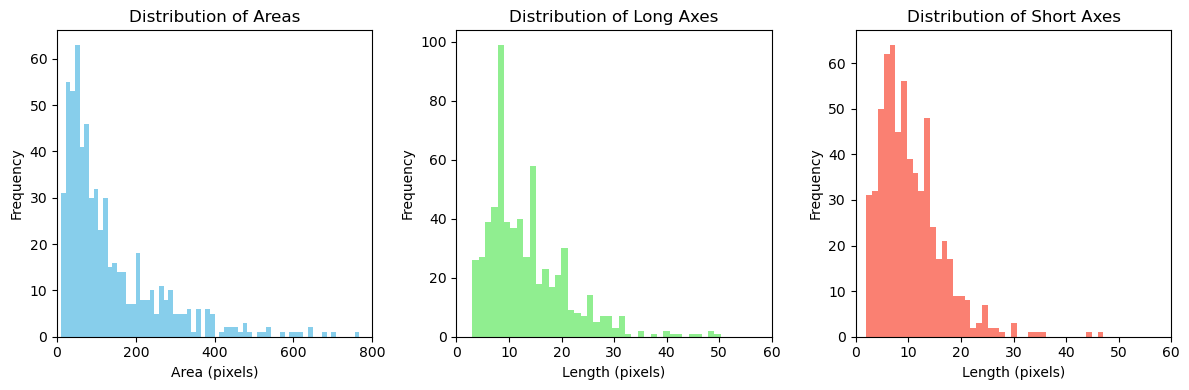

In [43]:
# Assuming you have collected 'areas', 'long_axes', and 'short_axes' data for all segments across images
# For demonstration, let's create some sample data

import numpy as np
import matplotlib.pyplot as plt

# Plotting the distribution of areas
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(areas, bins=500, color='skyblue')
plt.title('Distribution of Areas')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.xlim(0, 800)

# Plotting the distribution of long axes
plt.subplot(1, 3, 2)
plt.hist(long_axes, bins=80, color='lightgreen')
plt.title('Distribution of Long Axes')
plt.xlabel('Length (pixels)')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plotting the distribution of short axes
plt.subplot(1, 3, 3)
plt.hist(short_axes, bins=80, color='salmon')
plt.title('Distribution of Short Axes')
plt.xlabel('Length (pixels)')
plt.ylabel('Frequency')
plt.xlim(0, 60)

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Create a DataFrame from the series
data = pd.DataFrame({'Areas': areas, 'Long Axes': long_axes, 'Short Axes': short_axes})

# Print summary statistics for all three
print(data.describe())


             Areas   Long Axes  Short Axes
count   626.000000  626.000000  626.000000
mean    153.135783   13.522364   10.496805
std     282.977092    8.422464    6.682574
min      10.000000    3.000000    2.000000
25%      48.250000    8.000000    6.000000
50%      90.000000   12.000000    9.000000
75%     187.000000   17.000000   13.000000
max    5925.000000  100.000000   90.000000
